# Hard magnet tutorial – with AI-based property predictions

## Introduction

- This notebook demonstrates how to use the `mammos-ai` package to predict hard magnet properties using pre-trained machine learning models.
- This is the same workflow as the [hard magnet tutorial](./hard-magnet-tutorial.ipynb) but uses AI models to predict hysteresis properties instead of micromagnetic simulations.


Requirements:
- Software: `mammos`
- Basic understanding of [hard magnet tutorial](./hard-magnet-tutorial.ipynb)

In [1]:
%config InlineBackend.figure_format = "retina"


from pprint import pprint

import mammos_ai
import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np

# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Load data from DFT and spindynamics databases

In [2]:
material = "Co2Fe2H4"

results_dft = mammos_dft.db.get_micromagnetic_properties(material)
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization(material)

## Calculate micromagnetic intrinsic properties using Kuz’min formula

We use the Kuzmin equations to get intrinsic parameters Ms, A and K as inputs for the AI model. For each temperature we investigate, there is one triple of these parameters.

In [3]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.Ku_0,
)

The Curie temperature Tc, at which ferromagnetism breaks down, is

In [4]:
results_kuzmin.Tc

Entity(ontology_label='CurieTemperature', value=np.float64(1061.2857713503179), unit='K')

We show how the input parameters Ms, A and K vary as a function of temperature:

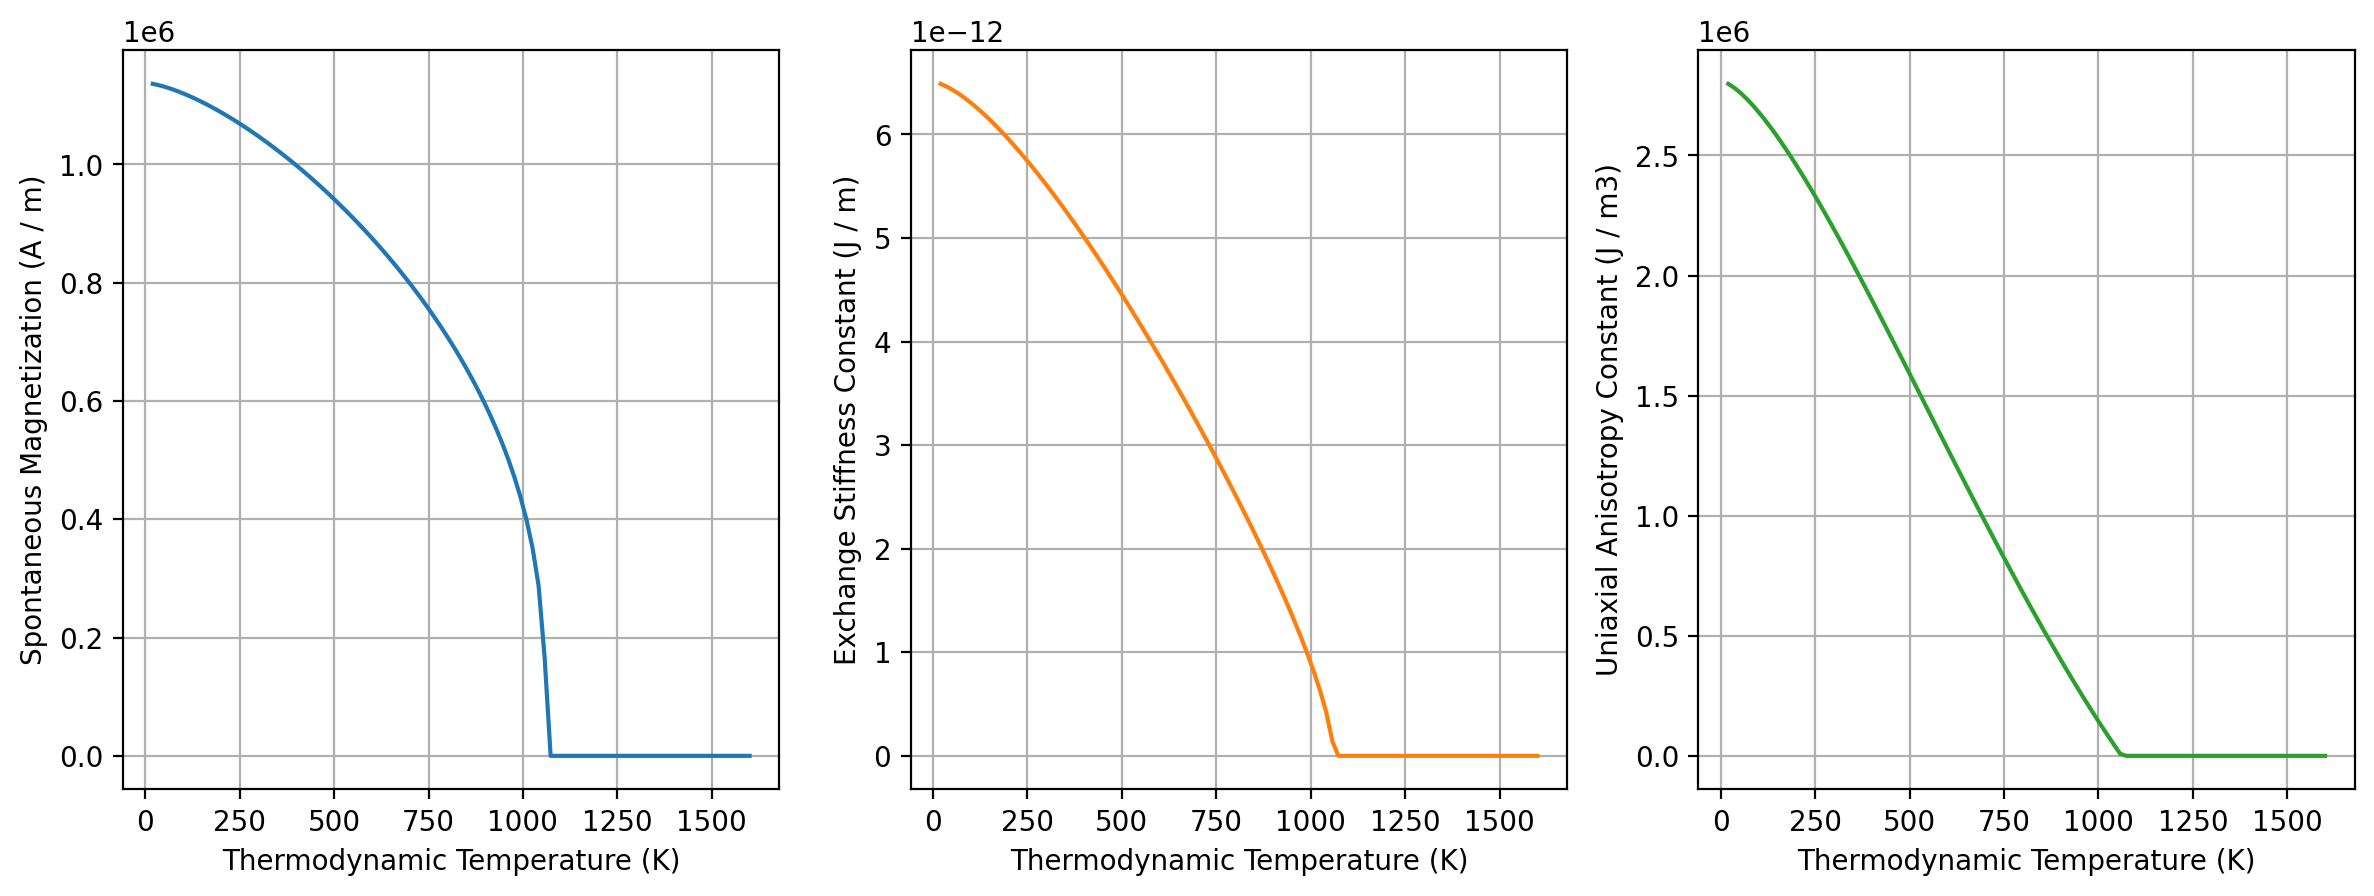

In [5]:
results_kuzmin.plot();

## AI-based prediction of extrinsic properties

Our aim now is to compute extrinsic properties remanent magnetization Mr, coercive field Hc and maximum energy product BHmax for multiple temperatures. 

Rather than running micromagnetic simulations to compute hysteresis loops and derive extrinsic properties from this, we use pre-trained machine learning models from the `mammos-ai` package.

Details about the model and its training data can be found in the [training repository](https://github.com/MaMMoS-project/ML-models/tree/main/beyond-stoner-wohlfarth/single-grain-easy-axis-model).

This AI-based approach allows for rapid estimates of hysteresis properties based on the intrinsic micromagnetic parameters computed earlier.

The model was trained using a 50 × 50 × 50 nm cubic grain with uniaxial anisotropy, where both the anisotropy axis and the applied magnetic field were oriented along a cube edge.

We prepare a number of temperatures for which we like predictions of the extrinsic parameters:

In [6]:
T = np.linspace(0, 0.95 * results_kuzmin.Tc.q, 20)

We limit the temperature range to stay below Tc, because above Tc we leave the ferromagnetic domain: the saturation magnetization Ms (and thus also Mr, Hc, and BHmax) are all zero. The AI model has not been trained outside the ferromagnetic domain. We show below how the training data range can be inspected.

For each of the temperatures, we get the input parameters Ms, A and K1 from the Kuzmin model, and ask the AI model to provide a prediction of the output parameters coercive field Hc, magnetic remanence Mr and maximum energy product BHMax:

In [7]:
results_ai = mammos_ai.Hc_Mr_BHmax_from_Ms_A_K(
    Ms=results_kuzmin.Ms(T),
    A=results_kuzmin.A(T),
    K1=results_kuzmin.K1(T),
)

This returns an `ExtrinsicProperties` object containing the predicted hysteresis properties. This is the same object type as returned by running micromagnetic simulations and then processing them with `mammos_analysis.hysteresis.extrinsic_properties` in the [hard magnet tutorial](https://mammos-project.github.io/mammos/demonstrator/hard-magnet-tutorial.html).

In [8]:
results_ai

ExtrinsicProperties(Hc=Entity(ontology_label='CoercivityHcExternal', value=array([2.93966750e+06, 2.89477400e+06, 2.79321925e+06, 2.78499750e+06,
       2.47932275e+06, 2.41681325e+06, 2.21677750e+06, 2.13166500e+06,
       1.87885688e+06, 1.93794362e+06, 1.79594075e+06, 1.83011238e+06,
       2.00786638e+06, 1.43980562e+06, 1.27694925e+06, 1.04018775e+06,
       1.06932975e+06, 1.09968988e+06, 1.18860275e+06, 8.29845375e+05],
      dtype=float32), unit='A / m'), Mr=Entity(ontology_label='Remanence', value=array([1.13617862e+06, 1.12959900e+06, 1.12572212e+06, 1.11436025e+06,
       1.09853262e+06, 1.08018725e+06, 1.08492800e+06, 1.06134412e+06,
       1.04196894e+06, 1.00015181e+06, 9.53664562e+05, 8.99243750e+05,
       8.18026875e+05, 7.79694688e+05, 7.59532438e+05, 7.44493062e+05,
       6.49421438e+05, 6.03753312e+05, 4.54241406e+05, 3.75777375e+05],
      dtype=float32), unit='A / m'), BHmax=Entity(ontology_label='MaximumEnergyProduct', value=array([405474.25 , 400786.62 , 398028

We can visualize the predicted extrinsic properties as a function of temperature;
starting with the remanence Mr:

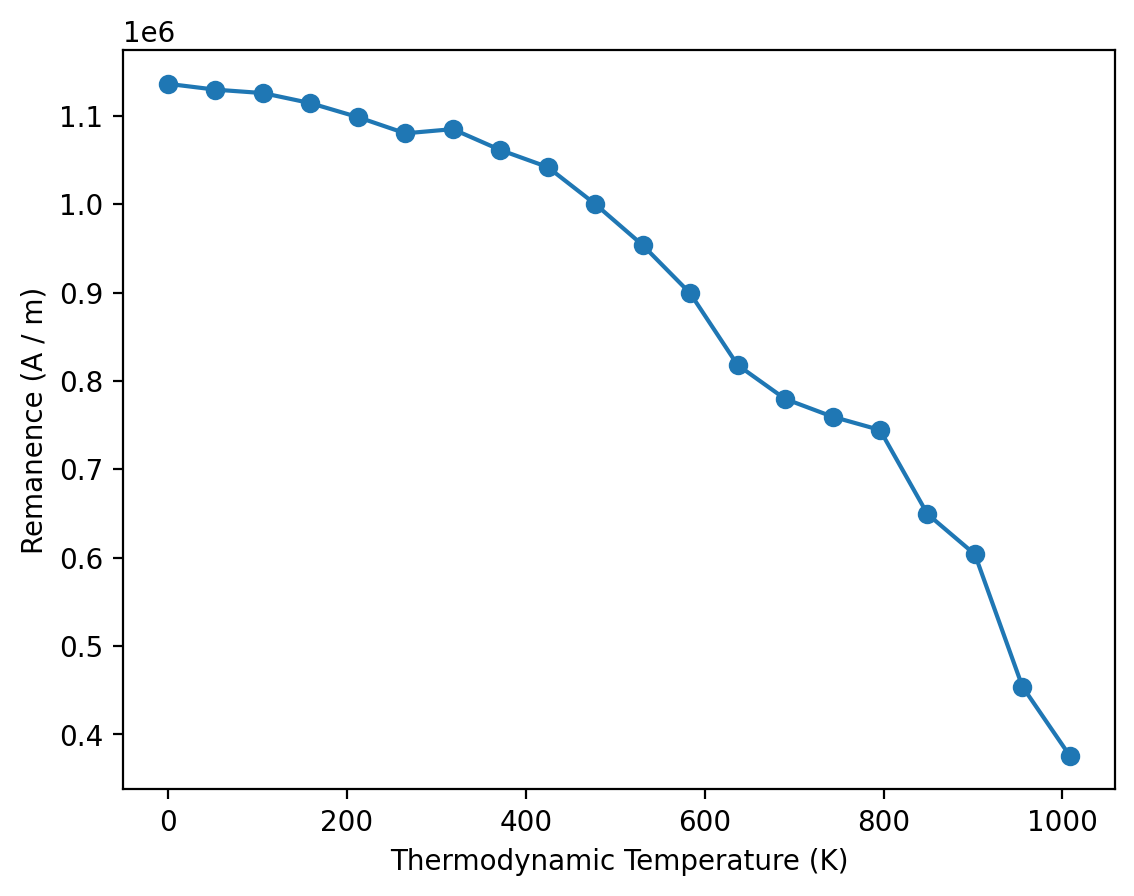

In [9]:
plt.plot(T, results_ai.Mr.value, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Mr().axis_label);

## Comparison with detailed micromagnetic simulations

To benchmark the predicted values of extrinsic properties, we compare the AI model output with the extrinsic properties obtained through `mammos-mumag` (FEM micromagnetic simulation tool) hysteresis loop calculations. These values have been computed before (using [these scripts](https://github.com/MaMMoS-project/mammos/tree/main/examples/data/hard-magnet-ai-surrogate-model)) because the execution of the runs providing the data (one hysteresis loop per temperature) takes several hours (using a V100 GPU).

In [10]:
properties_mumag = me.io.entities_from_file("data/hard-magnet-ai-surrogate-model/hystloop_extrinsic_properties.csv")
properties_mumag

EntityCollection(
    T=Entity(ontology_label='ThermodynamicTemperature', value=array([   0.        ,   53.07833835,  106.1566767 ,  159.23501504,
        212.31335339,  265.39169174,  318.47003009,  371.54836843,
        424.62670678,  477.70504513,  530.78338348,  583.86172183,
        636.94006017,  690.01839852,  743.09673687,  796.17507522,
        849.25341357,  902.33175191,  955.41009026, 1008.48842861]), unit='K'),
    Hc=Entity(ontology_label='CoercivityHcExternal', value=array([2957544.33841017, 2904496.66500872, 2851435.94316116,
       2745337.83773327, 2639233.22041202, 2533122.79787426,
       2400494.86038416, 2267862.4303985 , 2108714.10203368,
       1976075.21824152, 1816921.66979884, 1657765.43143012,
       1498606.66330497, 1339444.73416605, 1180277.61405979,
        994606.39144521,  835429.58265887,  649750.2166562 ,
        464058.9956854 ,  278315.62057954]), unit='A / m'),
    Mr=Entity(ontology_label='Remanence', value=array([1159972.91655059, 1152466.519593

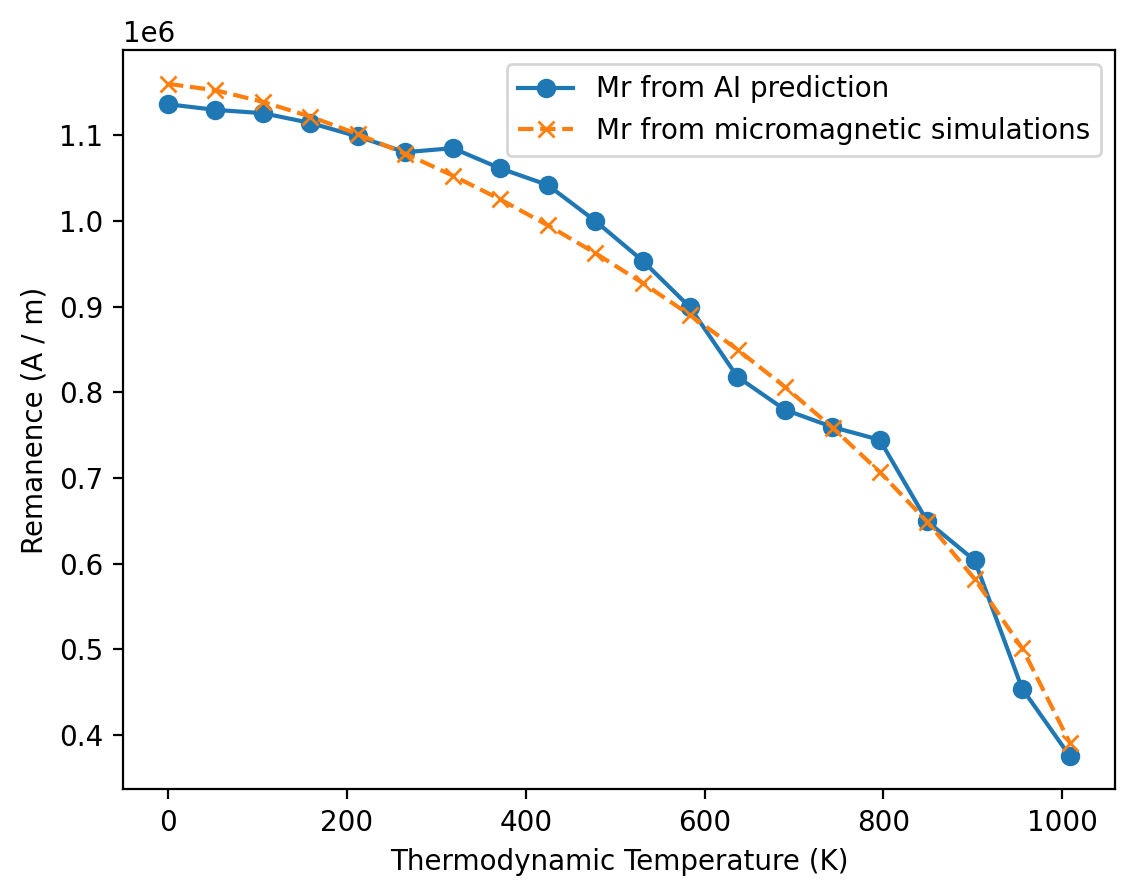

In [11]:
plt.plot(T, results_ai.Mr.value, linestyle="-", marker="o", label="Mr from AI prediction")
plt.plot(
    properties_mumag.T.value,
    properties_mumag.Mr.value,
    linestyle="--",
    marker="x",
    label="Mr from micromagnetic simulations",
)
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Mr().axis_label)
plt.legend();

We can also see how the coercive field changes with temperature:

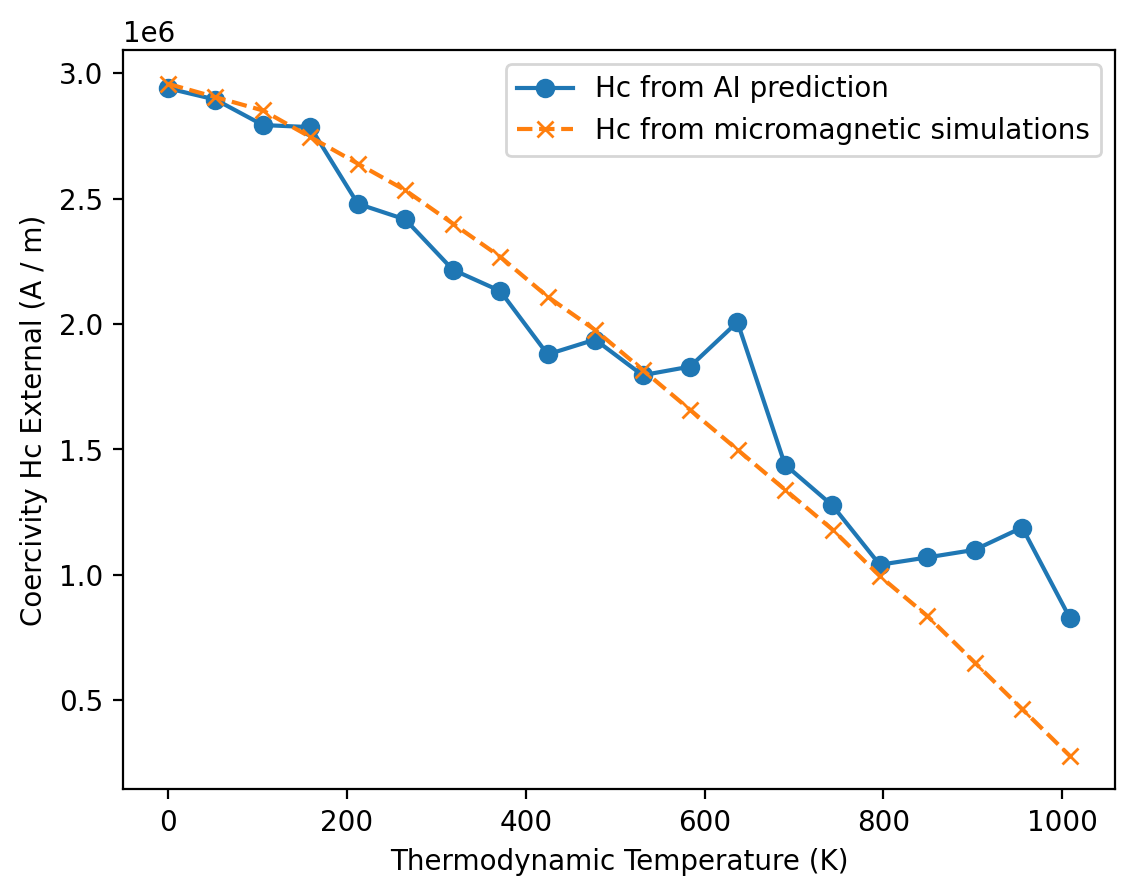

In [12]:
plt.plot(T, results_ai.Hc.value, linestyle="-", marker="o", label="Hc from AI prediction")
plt.plot(
    properties_mumag.T.value,
    properties_mumag.Hc.value,
    linestyle="--",
    marker="x",
    label="Hc from micromagnetic simulations",
)
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Hc().axis_label)
plt.legend();

Finally we look at the maximum energy product BHmax. 

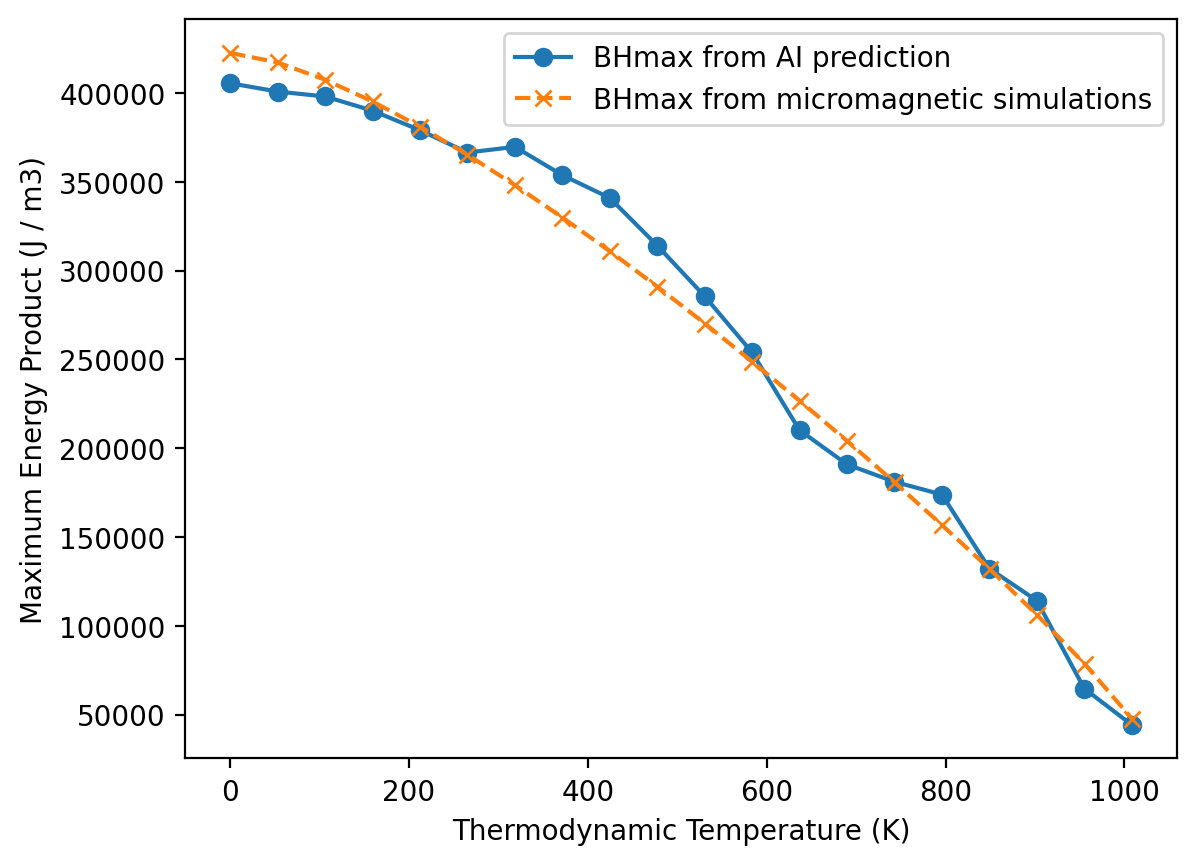

In [13]:
plt.plot(T, results_ai.BHmax.value, linestyle="-", marker="o", label="BHmax from AI prediction")
plt.plot(
    properties_mumag.T.value,
    properties_mumag.BHmax.value,
    linestyle="--",
    marker="x",
    label="BHmax from micromagnetic simulations",
)
plt.xlabel(me.T().axis_label)
plt.ylabel(me.BHmax().axis_label)
plt.legend();

The AI models show good agreement with micromagnetic simulations for the remanent magnetization (Mr), the coercive field (Hc), and the maximum energy product (BHmax).

In this notebook, we have shown how the `mammos-ai` package can serve as a fast alternative to full micromagnetic simulations for predicting the hysteresis properties of hard magnets. By using intrinsic micromagnetic parameters as inputs, the model provides rapid estimates that avoid the long runtime of micromagnetic simulations. 

It is important to not use the AI model outside its training range (see next section below).

# Ranges of validity

Asking for a coercivity field for a temperature above Tc is a somewhat unphysical question: Ms is zero, and thus Hc will be zero.
This is reflected in the AI model not being trained for Ms=0. 

We show how the training data range can be queried. 

Let us pretend that we want to extend the range of temperatures T2 that we want to study to values above Tc:

In [14]:
T2 = np.linspace(0.95 * results_kuzmin.Tc.q, 1.1 * results_kuzmin.Tc.q, 4)
T2

<Quantity [1008.22148278, 1061.28577135, 1114.35005992, 1167.41434849] K>

We can compute the corresponding values for the magnetization from the Kuzmin model:

In [15]:
Ms2 = results_kuzmin.Ms(T2).value
Ms2

array([402215.74629905,      0.        ,      0.        ,      0.        ])

What is the range of the training data for Ms for the `Hc_Mr_BHmax_from_Ms_A_K` model? We can find out with the `mammos_ai.Hc_Mr_BHmax_from_Ms_A_K_metadata()` function:

In [16]:
pprint(mammos_ai.Hc_Mr_BHmax_from_Ms_A_K_metadata()["training_data_range"])

{'A': (Entity(ontology_label='ExchangeStiffnessConstant', value=np.float64(1e-13), unit='J / m'),
       Entity(ontology_label='ExchangeStiffnessConstant', value=np.float64(1e-11), unit='J / m')),
 'K': (Entity(ontology_label='UniaxialAnisotropyConstant', value=np.float64(10000.0), unit='J / m3'),
       Entity(ontology_label='UniaxialAnisotropyConstant', value=np.float64(10000000.0), unit='J / m3')),
 'Ms': (Entity(ontology_label='SpontaneousMagnetization', value=np.float64(79580.0), unit='A / m'),
        Entity(ontology_label='SpontaneousMagnetization', value=np.float64(3980000.0), unit='A / m'))}


From this, we can see Ms=0 A/m is outside the training range, and thus no sensible prediction are possible.

If we, nevertheless, attempt to use the model outside its valid range, it produces unpredictable results. For example:


In [17]:
results_ai2 = mammos_ai.Hc_Mr_BHmax_from_Ms_A_K(
    Ms=results_kuzmin.Ms(T2),
    A=results_kuzmin.A(T2),
    K1=results_kuzmin.K1(T2),
)
results_ai2.BHmax

Entity(ontology_label='MaximumEnergyProduct', value=array([ 44292.707, 350828.28 , 350828.28 , 350828.28 ], dtype=float32), unit='J / m3')